In [1]:
from pure_functions import W_pred, corr_func, L_pred, smoother, solub, final_value, SED, file_finder

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize


In [86]:
class DataManager:
    def __init__(self, omni_filename="expttsd", imed_filename="imed"):
        self.omni_filename = "expttsd"
        self.imed_filename = "imed"
        self.omni_folder   = None
        self.DESC_best_W   = [2]
        self.DESC_best     = [1, 2]
        self.finaltime     = 10 # minutes
        self.colors        = ['orange','magenta','blue','red','green']
        self.conc_corr     = True
        self.sizedata      = []
        self.EVAL          = []
        self.popt          = [1,0]
        self.read_files    = []
        self.read_data_from = []
        
    def plot_generator(self):

        if len(self.EVAL) == 0:
            pass

        else:
            
            self.fig, self.axT = plt.subplots(len(self.EVAL)+1,4,figsize=(10,1.5*(len(self.EVAL)+1)))
            for i in range(len(self.EVAL)):
                E = self.EVAL[i]
                T1, WWW_1, LLL_1, SL1, SW1 = self.data_evaluator(E,70)
                
                
                self.axT[i,0].plot(T1,self.EVAL[i]['H01:External T'],'black',linestyle='--',alpha=0.9)
                ax_FBRM = self.axT[i,0].twinx()
                ax_FBRM.plot(T1,self.EVAL[i]['OPC R: Counts '],self.colors[i%5],linestyle='-',alpha=0.7)
                self.axT[i,0].set_xlabel(E.columns[0][0]+' '+'['+self.EVAL[i].columns[0][1]+']')
                self.axT[i,0].set_ylabel(E.columns[2][0]+'\n'+'['+self.EVAL[i].columns[2][1]+']')
                ax_FBRM.tick_params(axis='y', colors=self.colors[i%5])
                ax_FBRM.spines['right'].set_color(self.colors[i%5])
                ax_FBRM.set_ylabel(E.columns[4][0]+'\n'+'['+self.EVAL[i].columns[4][1]+']')
                self.axT[i,0].grid(True)
                ax_FBRM.set_ylim([0,80000])
                
                self.axT[i,1].plot(T1,self.EVAL[i]['H01:External T'],'black',linestyle='--',alpha=0.9)
                
                if self.conc_corr: #correction for UV-shift
                    ax_conc = self.axT[i,1].twinx()
                    bnds = ((1e-10, 100), (-10, 100))
                    x0 = np.array([1.1, 0.002])
                    conc_smooth_t,conc_smooth = smoother(E['File R: Conc '],T1,0,20)
                    conc_smooth = pd.DataFrame(conc_smooth)
                    X = [conc_smooth,solub(E['H01:External T'])]
                    res = minimize(corr_func, x0, args=(X), method='nelder-mead',bounds=bnds,options={'xatol': 1e-20, 'disp': False})
                    self.popt = [res.x[0],res.x[-1]]
                    ax_conc.plot(conc_smooth_t,self.popt[0]*X[0]+self.popt[1],c=self.colors[i%5],alpha=0.7)
                    
                else:
                    
                    ax_conc.plot(T1,self.popt[0]*self.EVAL[i]['File R: Conc ']+self.popt[1],c=self.colors[i%5],alpha=0.7)
                
                ax_conc.plot(T1,solub(E['H01:External T']),c=self.colors[i%5],alpha=0.5)
                self.axT[i,1].set_xlabel(E.columns[0][0]+' '+'['+self.EVAL[i].columns[0][1]+']')
                self.axT[i,1].set_ylabel(E.columns[2][0]+'\n'+'['+self.EVAL[i].columns[2][1]+']')
                ax_conc.set_ylabel(E.columns[-1][0]+'\n'+'['+self.EVAL[i].columns[-1][1]+']')
                ax_conc.tick_params(axis='y', colors=self.colors[i%5])
                ax_conc.spines['right'].set_color(self.colors[i%5])
                ax_conc.set_ylim([0.04,0.08])
                self.axT[i,1].grid(True)
                
                mask = (T1 > max(T1) - self.finaltime)
                
                self.axT[i,2].plot(T1,self.EVAL[i]['H01:External T'],'black',linestyle='--',alpha=0.9)
                ax_L = self.axT[i,2].twinx()
                ax_L.plot(T1,LLL_1,self.colors[i%5],linestyle='-',alpha=0.2)
                ax_L.plot(T1[mask],LLL_1.iloc[mask,:],self.colors[i%5],linestyle='-',alpha=0.9)    
                [ax_L.plot(SL1[0],SL1[j],self.colors[i%5], linestyle='-',alpha=0.9) for j in [1,2,3]]
                self.axT[i,2].set_xlabel(E.columns[0][0]+' '+'['+self.EVAL[i].columns[0][1]+']')
                self.axT[i,2].set_ylabel(E.columns[2][0]+' '+'['+self.EVAL[i].columns[2][1]+']')
                ax_L.tick_params(axis='y', colors=self.colors[i%5])
                ax_L.spines['right'].set_color(self.colors[i%5])
                ax_L.set_ylim([0,300])
                ax_L.set_ylabel('Length'+' '+'['+self.EVAL[i].columns[5][1]+']')
                self.axT[i,2].grid(True)
                
                ax_L.text(plt.xlim()[1]*(0.3),plt.ylim()[1]*1.05,f'Exp. no:{i : .0f}', color=self.colors[i%5])
                
                self.axT[i,3].plot(T1,self.EVAL[i]['H01:External T'],'black',linestyle='--',alpha=0.9)
                ax_W = self.axT[i,3].twinx()
                ax_W.plot(T1,WWW_1,self.colors[i%5],linestyle='-',alpha=0.2)
                ax_W.plot(T1[mask],WWW_1.iloc[mask,:],self.colors[i%5],linestyle='-',alpha=0.9)    
                [ax_W.plot(SW1[0],SW1[j],self.colors[i%5], linestyle='-',alpha=0.9) for j in [1,2,3]]
                self.axT[i,3].set_xlabel(E.columns[0][0]+' '+'['+self.EVAL[i].columns[0][1]+']')
                self.axT[i,3].set_ylabel(E.columns[2][0]+' '+'['+self.EVAL[i].columns[2][1]+']')
                ax_W.tick_params(axis='y', colors=self.colors[i%5])
                ax_W.spines['right'].set_color(self.colors[i%5])
                ax_W.set_ylabel('Width'+' '+'['+self.EVAL[i].columns[9][1]+']')
                self.axT[i,3].grid(True)
                ax_W.set_ylim([0,30])
                self.fig.tight_layout()
                
            for ax in self.axT[-1, :]:
                self.fig.delaxes(ax)
            
            pass

    def data_evaluator(self,E1,k):

        T1 = (E1['Time']).values.reshape(1,-1)[0] - (E1['Time'][0:1]).values[0]
        WWW_1 = pd.DataFrame(W_pred(np.array([E1[['OPC R: W10 ','OPC R: W50 ','OPC R: W90 ']].iloc[:,self.DESC_best_W]]))[0][:,:])
        LLL_1 = pd.DataFrame(L_pred(np.array([E1[['OPC R: L10 ','OPC R: L50 ','OPC R: L90 ']].iloc[:,self.DESC_best]]))[0][:,:])
        SL1 = [smoother(LLL_1,T1,2,k)[0],smoother(LLL_1,T1,0,k)[1],smoother(LLL_1,T1,1,k)[1],smoother(LLL_1,T1,2,k)[1]]
        SW1 = [smoother(WWW_1,T1,2,k)[0],smoother(WWW_1,T1,0,k)[1],smoother(WWW_1,T1,1,k)[1],smoother(WWW_1,T1,2,k)[1]]
        
        return T1, WWW_1, LLL_1, SL1, SW1
        
    def data_reader(self):
        
        for k,i in enumerate(file_finder(self.read_data_from,self.omni_filename)):

            if i not in self.read_files:
                E1 = pd.read_csv(i, header = [0, 1])
                T1, WWW_1, LLL_1, SL1, SW1 = self.data_evaluator(E1,70)
                VAL = pd.DataFrame({'Length':final_value(T1, WWW_1, self.finaltime),'Width': final_value(T1, LLL_1, self.finaltime), 'SED': SED(final_value(T1, LLL_1, self.finaltime),final_value(T1, WWW_1, self.finaltime))})        
                self.EVAL.append(E1)
                self.sizedata.append(VAL)
                self.read_files.append(i)

        pass
        

In [ ]:
# NEXT CHAPTER

In [123]:
#from scipy.io import loadmat
#from scipy.io import savemat


#data = loadmat(r"C:\Users\user\12. OMNIBUS-IMED integration\2025_12_10_init_models.mat", squeeze_me=True, struct_as_record=True)
#savemat(r"C:\Users\user\modified.mat", data, do_compression=False)
#data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Dec 10 11:15:04 2025',
 '__version__': '1.0',
 '__globals__': [],
 'No': 6,
 'Solubility': array((-34.34473349, 11.76895286, 5.5107691, 0, 0, 0, 0, 0),
       dtype=[('a', 'O'), ('b', 'O'), ('c', 'O'), ('d', 'O'), ('e', 'O'), ('f', 'O'), ('g', 'O'), ('h', 'O')]),
 'ProcInf': array([(1, 0.86, 1.4, 1, 0, 68, 0, 0, 6, 30, 1),
        (1, 0.86, 1.4, 1, 0, 68, 0, 0, 6, 30, 2),
        (1, 0.86, 1.4, 1, 0.0538, 68, 0, 0, 6, 30, 3),
        (1, 0.86, 1.4, 1, 0.0543, 69, 0, 0, 6, 30, 4),
        (1, 0.86, 1.4, 1, 0.27, 70, 0, 0, 6, 30, 5),
        (1, 0.86, 1.4, 1, 0.28, 80, 0, 0, 6, 30, 6)],
       dtype=[('AntiSolventDensity', 'O'), ('SolventDensity', 'O'), ('SolidDensity', 'O'), ('ShapeFactor', 'O'), ('SeedMass', 'O'), ('SolvMass', 'O'), ('AntiSolvMass', 'O'), ('PowerRatio', 'O'), ('Month', 'O'), ('Date', 'O'), ('No', 'O')]),
 'ExpData': array([(array([[0.0000000e+00, 1.8172000e+01, 3.6360000e+01, ..., 1.0083344e+04,
 

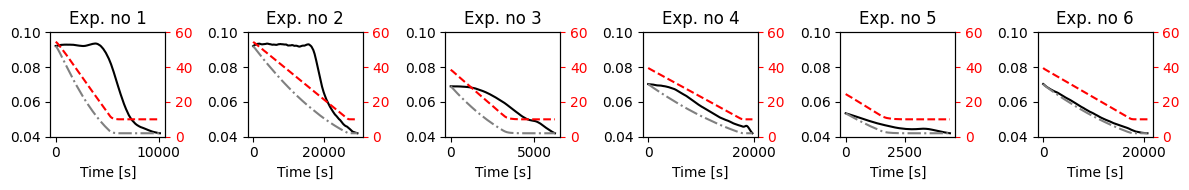

In [109]:
#fig, ax = plt.subplots(1,data['No'],figsize=(12,2) )
#for i in range(data['No']):
    
    #ax[i].plot(data['ExpData'][i][0][0],data['ExpData'][i][0][1],label='c',color='black')
    #ax[i].plot(data['ExpData'][i][4][0],solub(data['ExpData'][i][4][1]),'-.',label='sol',color='grey')
    #ax[i].set_xlabel("Time [s]")
    #ax[i].set_ylim([0.04,0.1])
    #ax[i].set_title(f'Exp. no {i+1:.0f}')
    #axT = ax[i].twinx()
    #axT.plot(data['ExpData'][i][4][0],data['ExpData'][i][4][1],'--',color='red',label='T')
    #axT.yaxis.label.set_color('red')
    #axT.tick_params(axis='y', colors='red')
    #axT.set_ylim([0,60])
    
#fig.tight_layout()